In [2]:
#import necessary libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import psutil
import os

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek


In [3]:
#Loading Dataset and Encoding
df = pd.read_csv("ThyroidDS.csv")

X = df.drop(columns=['target'])
y = df['target']

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [4]:
#Preprocessing Pipelines
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


In [5]:
#Train-Test Split and Balancing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=42
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_processed, y_train)
X_test_bal, y_test_bal = smote_tomek.fit_resample(X_test_processed, y_test)

print("Original class distribution:\n", pd.Series(y_encoded).value_counts())
print("\nBalanced training class distribution:\n", pd.Series(y_train_bal).value_counts())


Original class distribution:
 1    3012
0     151
Name: count, dtype: int64

Balanced training class distribution:
 1    2259
0    2259
Name: count, dtype: int64


In [6]:
#Feature Selection (XGBoost + SelectKBest)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

xgb_importance = pd.DataFrame({
    'Feature': range(X_train_bal.shape[1]),
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(19)

k_best = SelectKBest(score_func=f_classif, k=19)
k_best.fit(X_train_bal, y_train_bal)
top_19_kbest = list(np.where(k_best.get_support())[0])

combined_features = list(set(xgb_importance['Feature']).union(set(top_19_kbest)))
top_15_combined = combined_features[:15]

feature_names = preprocessor.get_feature_names_out()
selected_feature_names = [feature_names[i] for i in top_15_combined]
print("Top 15 Selected Features:\n", selected_feature_names)

X_train_sel = X_train_bal[:, top_15_combined]
X_test_sel = X_test_bal[:, top_15_combined]

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_sel)
X_test_scaled = sc.transform(X_test_sel)


Top 15 Selected Features:
 ['num__age', 'num__hypopituitary', 'num__TSH_measured', 'num__T3_measured', 'num__TT4_measured', 'num__T4U_measured', 'num__FTI', 'cat__sex_F', 'cat__sex_M', 'cat__on_thyroxine_f', 'cat__on_thyroxine_t', 'cat__query_on_thyroxine_f', 'cat__query_on_thyroxine_t', 'cat__on_antithyroid_meds_f', 'cat__on_antithyroid_meds_t']


In [8]:
#Define Models and Evaluation Function
mods = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=11, weights='distance', metric='manhattan')
}

def evaluate_model(name, mod, X_train, X_test, y_train, y_test):
    process = psutil.Process(os.getpid())

    start_train = time.time()
    mod.fit(X_train, y_train)
    end_train = time.time()

    start_pred = time.time()
    y_pred = mod.predict(X_test)
    end_pred = time.time()

    memory_usage = process.memory_info().rss / (1024 * 1024)

    return {
        'Model': name,
        'Train Time (s)': end_train - start_train,
        'Prediction Time (s)': end_pred - start_pred,
        'Memory Usage (MB)': memory_usage
    }

In [9]:
#Evaluation Before and After Feature Selection
results_before = [evaluate_model(name, mod, X_train_processed, X_test_processed, y_train, y_test) for name, mod in mods.items()]
results_after = [evaluate_model(name, mod, X_train_scaled, X_test_scaled, y_train_bal, y_test_bal) for name, mod in mods.items()]

df_before = pd.DataFrame(results_before)
df_after = pd.DataFrame(results_after)

print("Results Before Feature Selection:\n", df_before)
print("\nResults After Feature Selection:\n", df_after)

Results Before Feature Selection:
                Model  Train Time (s)  Prediction Time (s)  Memory Usage (MB)
0      Random Forest        0.500044             0.015595         237.468750
1  Gradient Boosting        1.143686             0.002484         237.453125
2      Decision Tree        0.011593             0.000000         237.453125
3     MLP Classifier        8.368009             0.000000         240.335938
4                KNN        0.000000             0.109371         240.570312

Results After Feature Selection:
                Model  Train Time (s)  Prediction Time (s)  Memory Usage (MB)
0      Random Forest        0.997834             0.038577         240.589844
1  Gradient Boosting        2.208230             0.000000         240.421875
2      Decision Tree        0.046875             0.000000         240.421875
3     MLP Classifier       14.531235             0.015623         240.906250
4                KNN        0.015638             0.249957         241.148438



--- Random Forest ---
Confusion Matrix:
[[732  20]
 [  8 744]]
Accuracy: 98.14%
Precision: 98.15%
Recall: 98.14%
F1 Score: 98.14%
Specificity: 97.34%
              precision    recall  f1-score   support

 hypothyroid       0.99      0.97      0.98       752
    negative       0.97      0.99      0.98       752

    accuracy                           0.98      1504
   macro avg       0.98      0.98      0.98      1504
weighted avg       0.98      0.98      0.98      1504



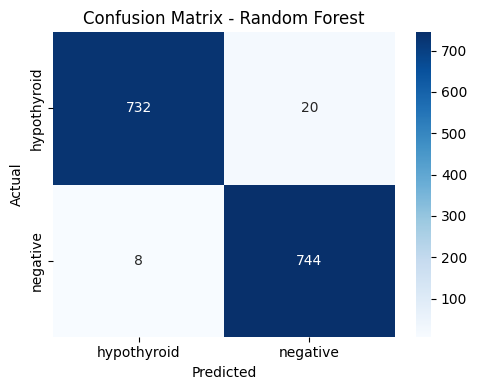


--- Gradient Boosting ---
Confusion Matrix:
[[726  26]
 [  5 747]]
Accuracy: 97.94%
Precision: 97.98%
Recall: 97.94%
F1 Score: 97.94%
Specificity: 96.54%
              precision    recall  f1-score   support

 hypothyroid       0.99      0.97      0.98       752
    negative       0.97      0.99      0.98       752

    accuracy                           0.98      1504
   macro avg       0.98      0.98      0.98      1504
weighted avg       0.98      0.98      0.98      1504



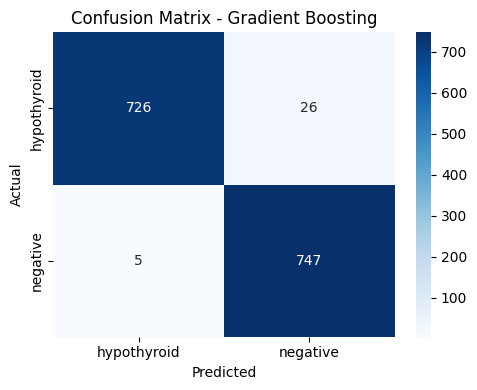


--- Decision Tree ---
Confusion Matrix:
[[723  29]
 [  6 746]]
Accuracy: 97.67%
Precision: 97.72%
Recall: 97.67%
F1 Score: 97.67%
Specificity: 96.14%
              precision    recall  f1-score   support

 hypothyroid       0.99      0.96      0.98       752
    negative       0.96      0.99      0.98       752

    accuracy                           0.98      1504
   macro avg       0.98      0.98      0.98      1504
weighted avg       0.98      0.98      0.98      1504



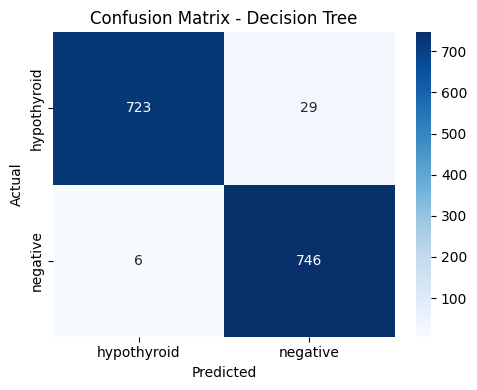


--- MLP Classifier ---
Confusion Matrix:
[[696  56]
 [  9 743]]
Accuracy: 95.68%
Precision: 95.86%
Recall: 95.68%
F1 Score: 95.67%
Specificity: 92.55%
              precision    recall  f1-score   support

 hypothyroid       0.99      0.93      0.96       752
    negative       0.93      0.99      0.96       752

    accuracy                           0.96      1504
   macro avg       0.96      0.96      0.96      1504
weighted avg       0.96      0.96      0.96      1504



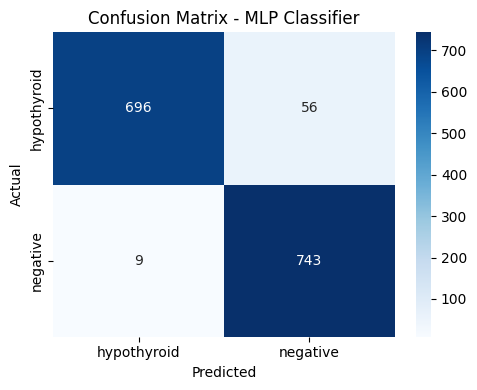


--- KNN ---
Confusion Matrix:
[[724  28]
 [ 22 730]]
Accuracy: 96.68%
Precision: 96.68%
Recall: 96.68%
F1 Score: 96.68%
Specificity: 96.28%
              precision    recall  f1-score   support

 hypothyroid       0.97      0.96      0.97       752
    negative       0.96      0.97      0.97       752

    accuracy                           0.97      1504
   macro avg       0.97      0.97      0.97      1504
weighted avg       0.97      0.97      0.97      1504



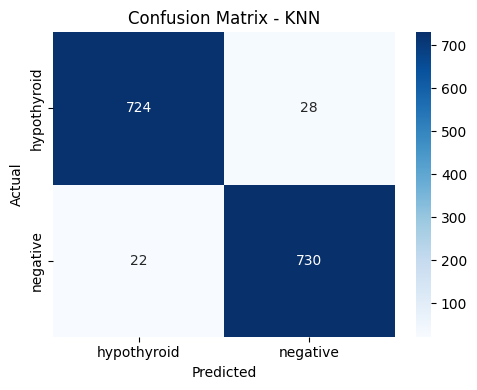

In [10]:
#Model Evaluation with Metrics and Plots
model_accuracies = {}
model_auc_scores = {}

def evaluate_model_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)

    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100
    specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
    auc_score = roc_auc_score(y_test, y_prob) * 100

    model_accuracies[model_name] = accuracy
    model_auc_scores[model_name] = auc_score

    print(f"\n--- {model_name} ---")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")
    print(f"Specificity: {specificity:.2f}%")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Train and evaluate each model
for name, model in mods.items():
    model.fit(X_train_scaled, y_train_bal)
    evaluate_model_metrics(model, X_test_scaled, y_test_bal, name)


In [16]:
#Hyperparameter Tuning (GB, RF, DT)
# Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.001]
}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train_sel, y_train_bal)
best_gb = grid_search_gb.best_estimator_

# Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_sel, y_train_bal)
best_rf = grid_search_rf.best_estimator_

# Decision Tree
param_grid_dt = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_dt.fit(X_train_sel, y_train_bal)
best_dt = grid_search_dt.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [17]:
#Ensemble Evaluation (Voting Classifier)
combinations = [
    (('gb', best_gb), ('rf', best_rf)),
    (('gb', best_gb), ('dt', best_dt)),
    (('rf', best_rf), ('dt', best_dt)),
    (('gb', best_gb), ('rf', best_rf), ('dt', best_dt))
]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def evaluate_ensemble_cv(voting_type, model_list, model_names):
    ensemble = VotingClassifier(estimators=model_list, voting=voting_type, weights=[1]*len(model_list) if voting_type=='soft' else None)
    scores = cross_val_score(ensemble, X_train_sel, y_train_bal, cv=skf, scoring='accuracy')
    avg_score = np.mean(scores) * 100
    print(f"{' + '.join(model_names)} ({voting_type.title()} Voting): {avg_score:.2f}%")
    return {'Model': ' + '.join(model_names), 'Voting': voting_type, 'Accuracy': avg_score}

results = []
for voting in ['hard', 'soft']:
    for combo in combinations:
        names = [name.upper() for name, _ in combo]
        results.append(evaluate_ensemble_cv(voting, list(combo), names))

df_results = pd.DataFrame(results)
pivoted = df_results.pivot(index="Model", columns="Voting", values="Accuracy").reset_index()
pivoted.columns = ['Model Name', 'Hard Voting (%)', 'Soft Voting (%)']
print("\nFinal Accuracy Table:\n")
print(pivoted.to_string(index=False))

GB + RF (Hard Voting): 99.05%
GB + DT (Hard Voting): 98.72%
RF + DT (Hard Voting): 98.74%
GB + RF + DT (Hard Voting): 99.11%
GB + RF (Soft Voting): 99.23%
GB + DT (Soft Voting): 99.14%
RF + DT (Soft Voting): 98.83%
GB + RF + DT (Soft Voting): 99.14%

Final Accuracy Table:

  Model Name  Hard Voting (%)  Soft Voting (%)
     GB + DT        98.716471        99.137021
     GB + RF        99.048427        99.225566
GB + RF + DT        99.114750        99.136972
     RF + DT        98.738644        98.827090


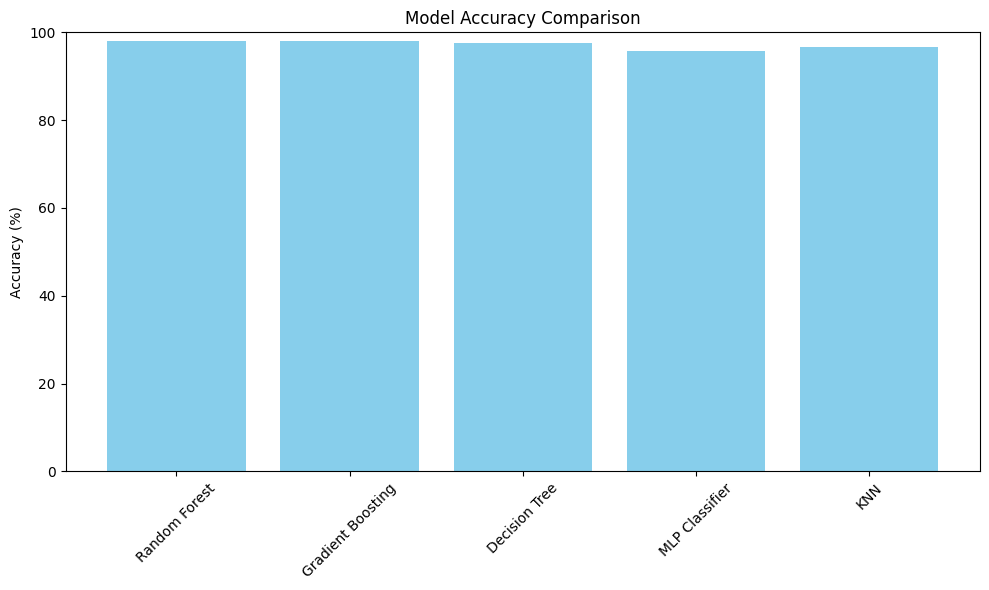


AUC Scores of All Classifiers:
Random Forest: 99.74%
Gradient Boosting: 99.59%
Decision Tree: 97.67%
MLP Classifier: 98.45%
KNN: 98.67%


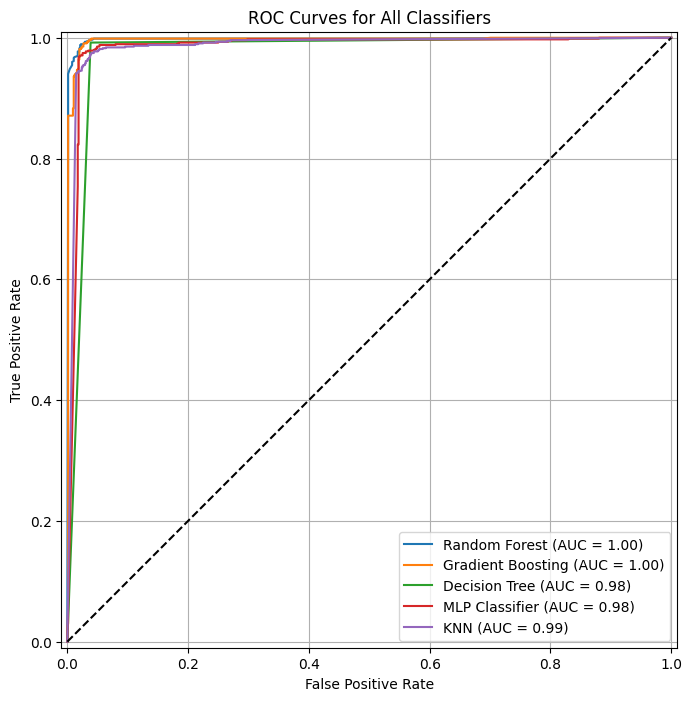

In [18]:
#Plotting Accuracy & ROC Curves
# Accuracy Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# AUC scores
print("\nAUC Scores of All Classifiers:")
for model_name, auc in model_auc_scores.items():
    print(f"{model_name}: {auc:.2f}%")

# ROC Curve
plt.figure(figsize=(10, 8))
for name, model in mods.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        RocCurveDisplay.from_predictions(y_test_bal, y_proba, name=name, ax=plt.gca())

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for All Classifiers")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

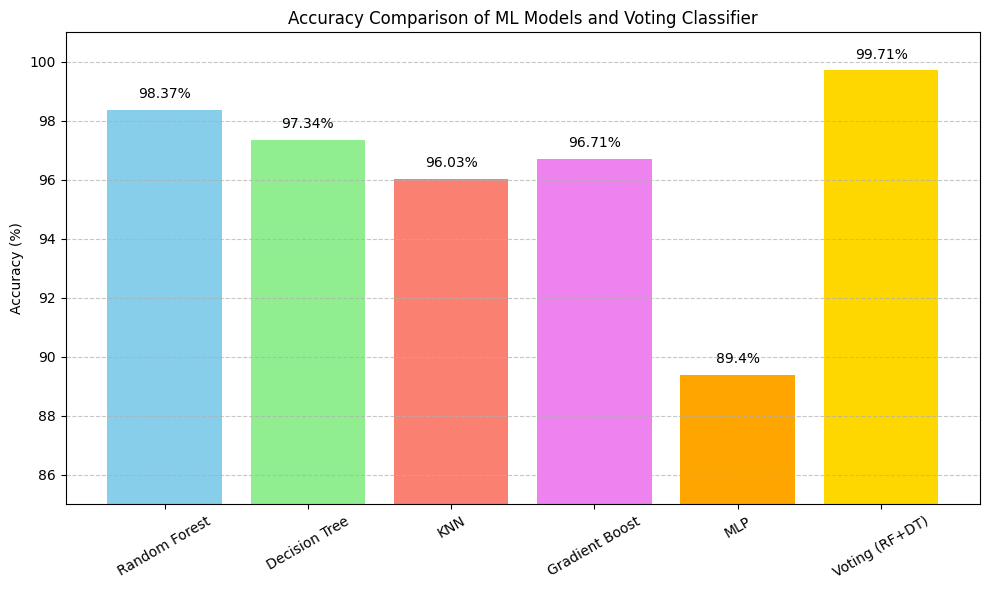

In [1]:
import matplotlib.pyplot as plt

# Accuracy scores of models (replace with your actual values if different)
model_names = ['Random Forest', 'Decision Tree', 'KNN', 'Gradient Boost', 'MLP', 'Voting (RF+DT)']
accuracies = [98.37, 97.34, 96.03, 96.71, 89.40, 99.71]  # example values in %

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'violet', 'orange', 'gold'])

# Annotating bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.3, f'{yval}%', ha='center', va='bottom', fontsize=10)

plt.title('Accuracy Comparison of ML Models and Voting Classifier')
plt.ylabel('Accuracy (%)')
plt.ylim(85, 101)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


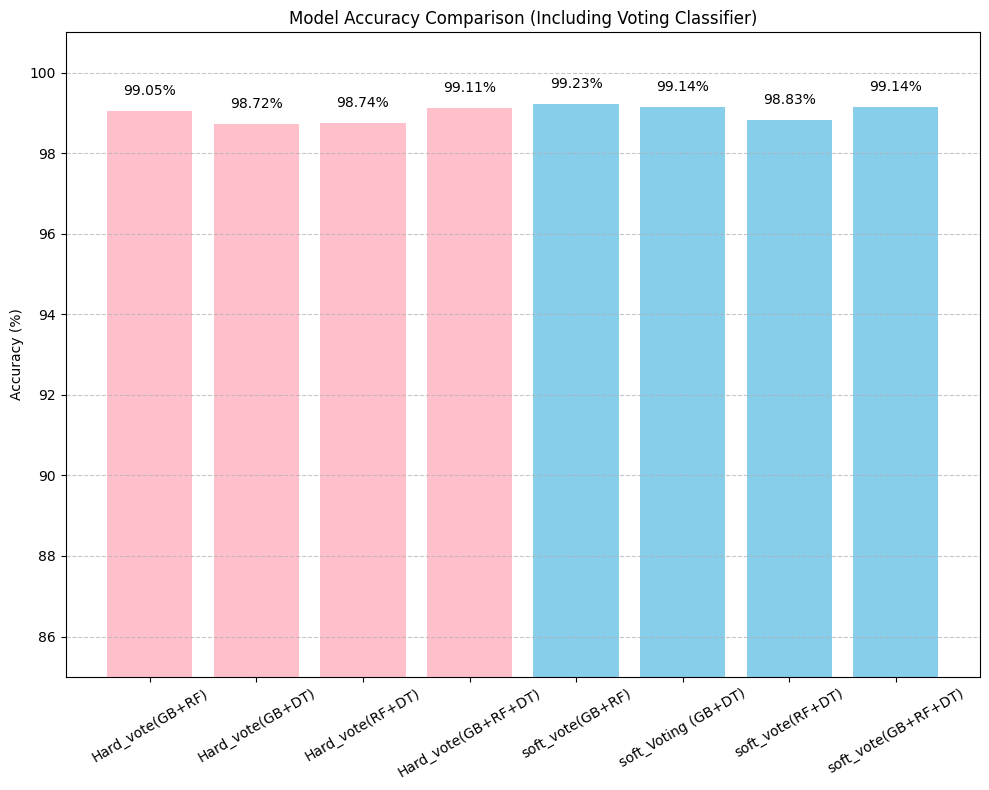

In [2]:
models = ['Hard_vote(GB+RF)', 'Hard_vote(GB+DT)', 'Hard_vote(RF+DT)', 'Hard_vote(GB+RF+DT)', 'soft_vote(GB+RF)', 'soft_Voting (GB+DT)', 'soft_vote(RF+DT)', 'soft_vote(GB+RF+DT)']
accuracies = [99.05, 98.72, 98.74, 99.11, 99.23, 99.14, 98.83, 99.14]  # Change these values as per your results

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.bar(models, accuracies, color=['pink', 'pink', 'pink', 'pink', 'skyblue', 'skyblue', 'skyblue', 'skyblue'])

# Annotate accuracy values on top
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 0.4,
             f'{bar.get_height()}%', ha='center', fontsize=10)

plt.title('Model Accuracy Comparison (Including Voting Classifier)')
plt.ylabel('Accuracy (%)')
plt.ylim(85, 101)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()